In [47]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
import scipy.optimize as opt
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from mycolorpy import colorlist as mcp
from Fhcalc import *
from ErrMask import *

### Construct a Gaussian E-field screen

In [89]:
# parameter initialization
N_screen = 4096 # 8192 for figures in the paper; this only changes the leakage amplitude, irrelevant to the pattern we're studying 
N_theta = 1024# 1024
D = 15.0
sigma = 1.0
thetamaxdeg = 5.0 # interpolate from -5 deg to +5 deg 


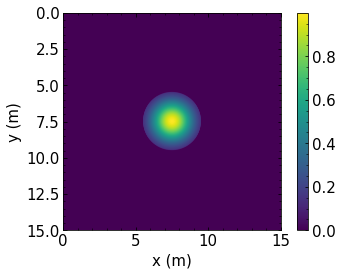

In [90]:
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma) # Gaussian E-field
InCircle(screen, center, 2.0) # circular truncation
ScreenFFT(screen) # take FT of the screen

plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar()


### Calculate the interpolated on-sky beam in $\theta$ space

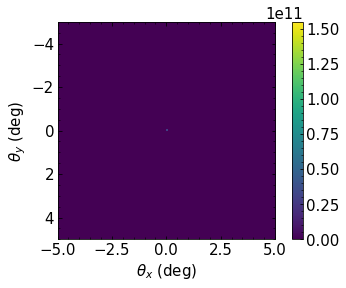

In [91]:
lam = 0.002 #m wavelength
thetamax = thetamaxdeg*np.pi/180. # degree to radian
theta_vec = np.linspace(-thetamax,thetamax,N_theta)  
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) # interpolation
plt.imshow(II0, extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg))
plt.xlabel(r'$\theta_x$ (deg)')
plt.ylabel(r'$\theta_y$ (deg)')
plt.colorbar()

### Calculate the beam window in $\ell$ space

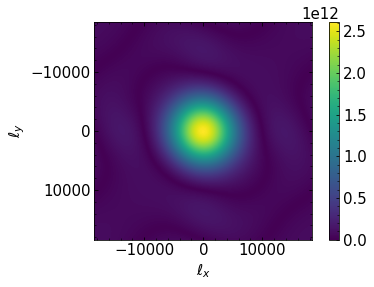

In [92]:
# FT of sky intensity - beam window
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in 1/rad (l) space

#calculate l
theta_vec = np.linspace(0, 2*thetamax, N_theta) # shift coordinates, easy to convert to l
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

plt.imshow(fft_I0, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min()))
plt.xlabel(r'$\ell_x$')
plt.ylabel(r'$\ell_y$')
plt.colorbar()

### Beam window verification 

consistent with the analytical solution $e^{-\frac{1}{2}\ell(\ell+1)\sigma^2}$ where $\sigma$ is the on-sky beam width. This is defined in Fhcalc.py.

One may want to increase the circular truncation radius to 4-Gaussian-$\sigma$, for example, defined in the second code cell for a better match. 

In [93]:
# bin sky intensity radially
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt((thetax-thetax.max()/2)**2 + (thetay-thetay.max()/2)**2)
bins = np.linspace(0,theta_r.max(),int(len(theta_vec)/1.2))
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_I0, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bins) 

# fit 1D in sky (rad space)
# ### this uses the central horizontal slice of data
# (fit, err) = opt.curve_fit(gaussian, theta_vec, II0[int(n/2)], p0=np.array([II0[int(n/2)].max(), 0.00026, theta_vec.max()/2]), absolute_sigma=True)
# beam_sky = gaussian(theta_vec, fit[0], fit[1], fit[2])

### this uses the binned sky intensity
(fit, err) = opt.curve_fit(gaussian, bins[:-1], bin_I0, p0=np.array([II0[int(n/2)].max(), 0.00026, 0.0]), absolute_sigma=True)
#beam_sky = gaussian(theta_vec, fit[0], fit[1], theta_vec.max()/2)
beam_sky = gaussian(theta_vec, fit[0], fit[1], 0)
print('on-sky beam sigma is {:.5f} rad or {:.3f} deg'.format(fit[1], fit[1]*180/np.pi))


# numerical: average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(l_vec)/2))
l_flatten = l.flatten()
fft_numerical = fft_I0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical, statistic='mean', bins=bin_edges) 
print(fit)

on-sky beam sigma is 0.00025 rad or 0.015 deg
[ 1.46974412e+11  2.54353742e-04 -5.81074818e-06]


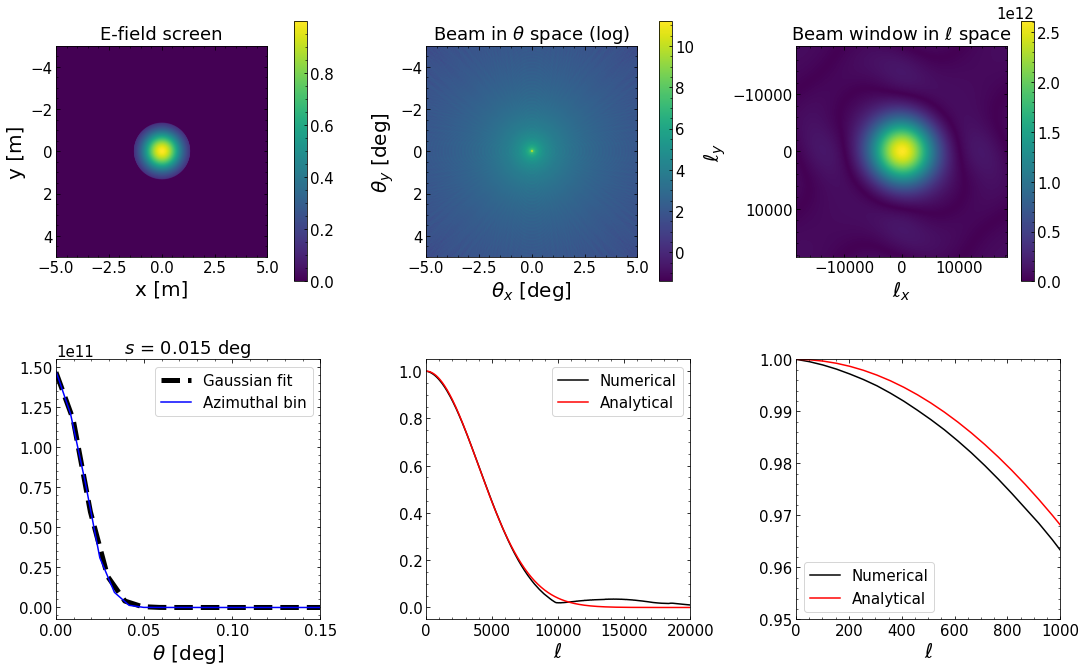

In [94]:
fig = plt.figure(figsize=(18,11))
plt.subplots_adjust(wspace=0.4,
                    hspace=0.3)

plt.subplot(2,3,1)
plt.imshow(screen['E'], interpolation=None, extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg)) 
plt.xlabel('x [m]', fontsize=20)
plt.ylabel('y [m]', fontsize=20)
plt.title('E-field screen', fontsize=18)
plt.colorbar(anchor=(0.5, 0.))
plt.subplot(2,3,2)
plt.imshow(np.log10(II0), interpolation=None, extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg)) 
plt.colorbar(anchor=(0.3, 0.))
plt.xlabel(r'$\theta_x$ [deg]', fontsize=20)
plt.ylabel(r'$\theta_y$ [deg]', fontsize=20)

plt.title(r'Beam in $\theta$ space (log)', fontsize=18)
plt.subplot(2,3,3)
plt.imshow(fft_I0, interpolation=None, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min())) 
plt.colorbar()
plt.xlabel(r'$\ell_x$', fontsize=20)
plt.ylabel(r'$\ell_y$', fontsize=20)
plt.title(r'Beam window in $\ell$ space', fontsize=18)
plt.subplot(2,3,4)
plt.plot(theta_vec*180/np.pi, beam_sky, ls='--', lw=5, color='black', label='Gaussian fit')
plt.plot((bins[:-1])*180/np.pi, bin_I0, color='blue', label='Azimuthal bin')
plt.title(r'$s$ = {:.3f} deg'.format(fit[1]*180/np.pi), fontsize=18)
plt.xlabel(r'$\theta$ [deg]', fontsize=20)
#plt.xlim(0.5*theta_vec.max(), 0.525*theta_vec.max())
plt.xlim(0,0.15)
plt.legend(loc='upper right')
#plot analytical & numerical solutions
plt.subplot(2,3,5)
plt.plot(bin_edges[:-1], bin_mean0/bin_mean0.max(), color='black', label='Numerical')
plt.plot(bin_edges, analytical(bin_edges, fit[1], bin_mean0.max())/bin_mean0.max(), color='red', label='Analytical')
plt.xlabel(r'$\ell$', fontsize=20)
plt.xlim(0,20000)
plt.legend()
plt.subplot(2,3,6)
plt.plot(bin_edges[:-1], bin_mean0/bin_mean0.max(), color='black', label='Numerical')
plt.plot(bin_edges, analytical(bin_edges, fit[1], bin_mean0.max())/bin_mean0.max(), color='red', label='Analytical')
plt.xlabel(r'$\ell$', fontsize=20)
plt.xlim(0,1000)
plt.ylim(0.95, 1.0)
plt.legend()

#plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Paper_SrProj/Figures/Verification_h.png', dpi=600, bbox_inches='tight')

### Adding errors 

perturb the E-field screen with an error mask (see functions in ErrMask.py).

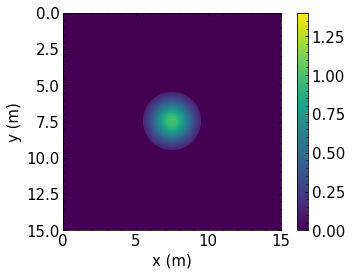

In [95]:
option = 'amp' # 'phase' ### amplitude or phase perturbation 
A = 1.0 # scaling factor of the error mask 
kin = 15
kout = kin+10


screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, sigma)
InCircle(screen1, center, 2.0)

if option=='phase':
    emap_E = filter_annulus_phase(screen1, A, kin, kout)
elif option=='amp':
    emap_E = filter_annulus_amp(screen1, A, kin, kout)

plt.imshow(screen1['E'],extent=(0,screen1['D'],screen1['D'],0))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar()

### Differenced beam leakage window function

difference the perturbed and unperturbed beam window; find the leakage power.

In [96]:
# interpolate the perturbed beam 
ScreenFFT(screen1)
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
II1 = II1 * (np.sum(II0)/np.sum(II1)) # normalize the perturbed beam --> matching powers
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

# FT of sky intensity
I_diff = II0 - II1 # take the difference in theta space (sky)
fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

# average (FT of II0)^2 radially 
bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
l_flatten = l.flatten()
fft_numerical0 = fft_I0.flatten()
fft_numerical1 = fft_I1.flatten()
fft_numerical_diff = fft_Idiff.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
l_vec = bin_edges[0:-1] # ell 1D vector

beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
#error = np.mean(beam_diff_rela[1:3]) #for maxdeg=3.0
error = np.mean(beam_diff_rela[(l_vec>=49)&(l_vec<=251)]) # average the beam difference between 0<l<500
print('beam_diff / perfect beam = ', error)
print('leakage = ', error**2)

# Calculates the noise level in fourier space (V^2/Hz)
emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2

### noise normalization
idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
total_Vf = np.sum(norm_fft)*screen1['dk']**2
rms_sq = np.abs(rms(emap_E)**2)
print('Normalized k space power is = ',total_Vf)
print('RMS^2 = ', rms_sq)
# print('average error is ', avg_fft)
# print('leakage (error^2) = {}'.format(error**2))



beam_diff / perfect beam =  0.016170139475042603
leakage =  0.00026147341064233103
Normalized k space power is =  0.016910766364115818
RMS^2 =  0.01691076636411583


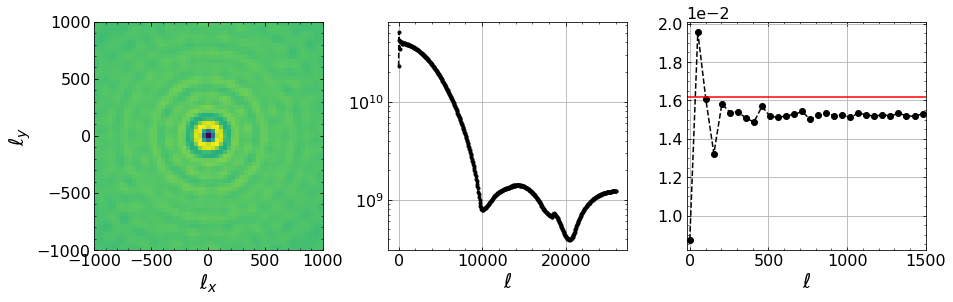

In [97]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(15,4.2))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

ax1 = fig.add_subplot(1,3,1)
#fig.tight_layout(pad=5.0)
ax1.imshow(fft_Idiff, interpolation=None, extent=(l_x.min(), l_x.max(), l_y.max(), l_y.min())) 
#plt.imshow(fft_Idiff, interpolation=None) 
#ax1.set_colorbar()
ax1.set_xlabel(r'$\ell_x$', fontsize=20)
ax1.set_ylabel(r'$\ell_y$', fontsize=20)
ax1.set_xlim(-1000,1000)
ax1.set_ylim(-1000,1000)
#ax1.set_title('Beam Difference')
#pcm = ax1.pcolormesh(fft_Idiff)
#fig.colorbar(pcm, ax=ax1, anchor=(0.5, 0.5))

ax2 = fig.add_subplot(1,3,2)
ax2.semilogy(l_vec,bin_mean_diff, 'o--', ms=3, color='black', label='Beam difference') 
ax2.set_xlabel(r'$\ell$', fontsize=20)
#plt.legend()
ax2.grid()
#plt.xlim(-10,2e4)

ax3 = fig.add_subplot(1,3,3)
ax3.plot(l_vec, beam_diff_rela,'o--', color='black', label='Fractional difference')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
ax3.set_xlabel(r'$\ell$', fontsize=20)
plt.axhline(error, color='red')
ax3.set_xlim(-20,1500)
ax3.grid()

### Leakage and $\Delta r$ vs. systematic errors

Now iterate through multiple error masks with varying noise levels. 

For each perturbed screen, calculate the leakage power and the bias in $r$, and measure the normalized noise level of each mask. 


In [98]:
# input and initialize parameters
N_screen = 2048 # 8192 for paper figures 
N_theta = 1024 # 1024 
D = 15.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option ='amp' # or 'phase'
leak = np.array([]) # leakage
noise_norm = np.array([]) # normalized noise
#amp = np.array([0.5,1.0]) # test
RMS_real = np.array([]) 
# amp = np.arange(0.01, 0.3, 0.05) # test
amp = np.arange(0.01, 0.3, 0.02) # scaling factor of amplitude errors
# amp = np.arange(0.1,1.21,0.05) # scaling factor of phase errors
kin = 15
kout = 25
r = np.array([]) # bias in r

# LCDM CMB power spectra from https://lambda.gsfc.nasa.gov/toolbox/camb_online.html
(ll, T, E, B) = np.loadtxt('camb_96896687_totcls.dat.txt', unpack=True, usecols=(0,1,2,3))

def rms(x):
    return np.sqrt(np.mean(x**2))


# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in theta space [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for i in range(len(amp)):
    print('amp = ', amp[i])
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)
    
    if option=='phase':
        emap_E = filter_annulus_phase(screen1, amp[i], kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, amp[i], kin, kout)
    else: print('Choose phase or amplitude errors')
    
    ScreenFFT(screen1)
    
    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) # normalize the perturbed beam
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad
    
    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space
    
    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    # fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    # bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector
    
    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    leak = np.append(leak, np.mean(beam_diff_rela[(l_vec>=50)&(l_vec<=250)])**2) # average the beam difference at l=85 and l=170 (2nd and 3rd elements)
    print('Error amplitude = {}, leakage (error^2) = {:.3e}'.format(amp[i], leak[i]))
    
    ### plot the leakage spectrum and T->B power spectrum
    spline = interp.InterpolatedUnivariateSpline(l_vec, beam_diff_rela**2, k=1)
    leakage = spline(ll)
    # plt.loglog(ll,T*leakage, label='leakage {}'.format(amp[i])) 
    
    ### calculate bias in r
    want = np.where((ll<250)&(ll>50))
    B0 = np.mean(B[want]) # BB power averaged over 50<l<250 at r=1
    B_leak = np.mean(T[want]*spline(ll[want]))
    r = np.append(r, 1 * (B_leak / B0)) # bias in r averaged over 50<l<250
    print('Delta r = ', r[i])
    
    # Calculates the noise level in fourier k space 
    emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
    norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
    avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_fft)*screen['dk']**2
    rms_sq = np.abs(rms(emap_E)**2)
#     print('Normalized noise in k space = ',total_Vf)
#     print('RMS^2 in real space = ', rms_sq)
    noise_norm = np.append(noise_norm, avg_fft)
    RMS_real = np.append(RMS_real, np.sqrt(rms_sq))
    
print('Done')

amp =  0.01
Error amplitude = 0.01, leakage (error^2) = 4.290e-11
Delta r =  4.0665767455924716e-06
amp =  0.03
Error amplitude = 0.03, leakage (error^2) = 3.161e-09
Delta r =  0.00030061225295085385
amp =  0.049999999999999996
Error amplitude = 0.049999999999999996, leakage (error^2) = 2.556e-08
Delta r =  0.0024303766102964667
amp =  0.06999999999999999
Error amplitude = 0.06999999999999999, leakage (error^2) = 1.008e-07
Delta r =  0.009572368811142028
amp =  0.08999999999999998
Error amplitude = 0.08999999999999998, leakage (error^2) = 2.774e-07
Delta r =  0.026383419481943178
amp =  0.10999999999999997
Error amplitude = 0.10999999999999997, leakage (error^2) = 6.231e-07
Delta r =  0.059276887210199795
amp =  0.12999999999999998
Error amplitude = 0.12999999999999998, leakage (error^2) = 1.241e-06
Delta r =  0.11796600777811087
amp =  0.15
Error amplitude = 0.15, leakage (error^2) = 2.123e-06
Delta r =  0.20186299632951507
amp =  0.16999999999999998
Error amplitude = 0.16999999999999

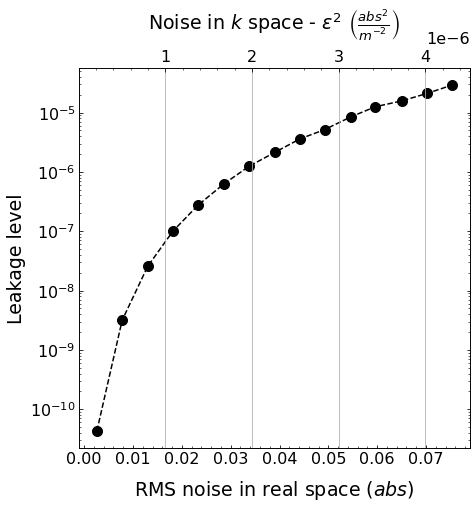

In [99]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.semilogy(RMS_real, leak, 'o--', ms=10, color='black')
ax1.set_xlabel('RMS noise in real space ($abs$)', fontsize=19)
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.xaxis.set_label_coords(.5, -0.08)

ax2.xaxis.set_label_coords(.5, 1.1)
ax2.set_xlim(noise_norm.min(), noise_norm.max())
ax2.set_xlabel(r'Noise in $k$ space - $\epsilon^2$ $\left(\frac{abs^2}{m^{-2}}\right)$', fontsize=19)
#plt.show()
plt.grid()

#plt.savefig('')

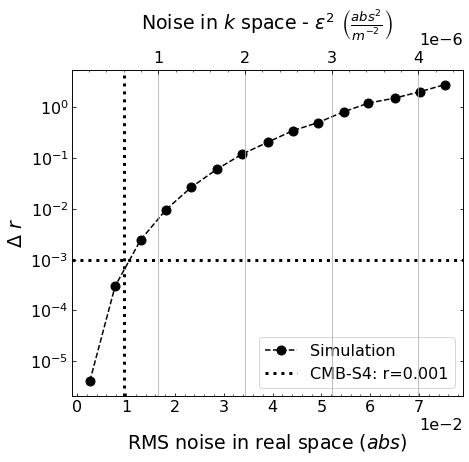

In [106]:
fig = plt.figure(figsize=(7,6))
ax1 = fig.add_subplot(111)
ax1.semilogy(RMS_real, r, 'o--', ms=9, color='black', label='Simulation')
spl = interp.InterpolatedUnivariateSpline(r, RMS_real, k=1)
# check interpolation
# x = np.linspace(-5, 0, 20)
# plt.plot(spl(10**x), 10**x)
plt.axvline(spl(0.001), ls=':', lw=3, color='black')
plt.axhline(0.001, ls=':', lw=3, label='CMB-S4: r=0.001', color='black')
ax1.set_xlabel('RMS noise in real space ($abs$)', fontsize=19)
ax1.xaxis.set_label_coords(.5, -0.11)

ax1.set_ylabel(r'$\Delta$ $r$', fontsize=19)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(loc='lower right')
ax2 = ax1.twiny()
#plt.axvline(1.94e-7, ls=':', lw=3, color='red')

ax2.xaxis.set_label_coords(.5, 1.122)
ax2.set_xlim(noise_norm.min(), noise_norm.max())
ax2.set_xlabel(r'Noise in $k$ space - $\epsilon^2$ $\left(\frac{abs^2}{m^{-2}}\right)$', fontsize=19)
plt.grid()


### Leakage power spectra

amp =  0.045
Error amplitude = 0.045, leakage (error^2) = 1.060e-09
Delta r =  0.00010056842646206995
Normalized noise in k space =  3.42063725260936e-05
RMS^2 in real space =  3.42063725260936e-05
amp =  0.11
Error amplitude = 0.11, leakage (error^2) = 3.910e-08
Delta r =  0.0037159093198511272
Normalized noise in k space =  0.00020411529338532484
RMS^2 in real space =  0.00020411529338532547
amp =  0.8
Error amplitude = 0.8, leakage (error^2) = 1.024e-04
Delta r =  9.731245172964401
Normalized noise in k space =  0.010788787814887929
RMS^2 in real space =  0.010788787814887917
Done


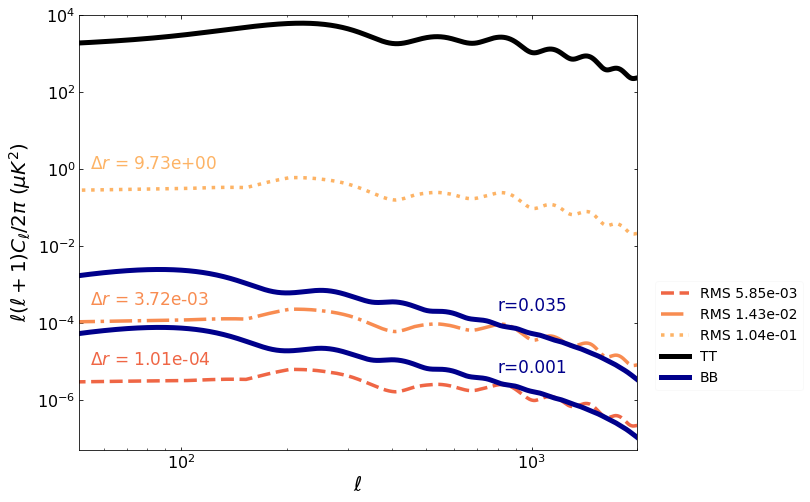

In [111]:
# input and initialize parameters
N_screen = 4096
N_theta = 1024
D = 15.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option ='amp' # or 'phase'
leak = np.array([])
noise_norm = np.array([])
#amp = np.array([0.5,1.0]) # test
RMS_real = np.array([])
#amp = np.array([0.045, 0.15, 1.0]) 
amp = np.array([0.045, 0.11, 0.8])
kin = 15
kout = 25
r = np.array([])
cl = ['#ef6645', '#f88c51', '#fdb365']
ls = ['--', '-.', ':']

# LCDM CMB power spectra from https://lambda.gsfc.nasa.gov/toolbox/camb_online.html
(ll, T, E, B) = np.loadtxt('camb_96896687_totcls.dat.txt', unpack=True, usecols=(0,1,2,3)) # B at r=1
B_032 = np.loadtxt('camb_41507785_totcls.dat.txt', unpack=True, usecols=(3)) # current best B mode constraint r=0.032
(ll_r, T_r, B_r) = np.loadtxt('camb_52566576_totcls.dat.txt', unpack=True, usecols=(0,1,3)) # CMB-S4 future constraint, r at 0.001

def rms(x):
    return np.sqrt(np.mean(x**2))


# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.0)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

fig = plt.figure(figsize=(10,8))

for i in range(len(amp)):
    print('amp = ', amp[i])
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.0)
    
    if option=='phase':
        emap_E = filter_annulus_phase(screen1, amp[i], kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, amp[i], kin, kout)
    else: print('Choose phase or amplitude errors')
    
    ScreenFFT(screen1)
    
    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) # normalize the perturbed beam
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad
    
    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space
    
    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    # fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    # bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector
    
    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    leak = np.append(leak, np.mean(beam_diff_rela[(l_vec>=50)&(l_vec<=250)])**2) # average the beam difference at l=85 and l=170 (2nd and 3rd elements)
    print('Error amplitude = {}, leakage (error^2) = {:.3e}'.format(amp[i], leak[i]))
    
    ### plot the leakage spectrum and T->B power spectrum
    spline = interp.InterpolatedUnivariateSpline(l_vec, beam_diff_rela**2, k=1)
    leakage = spline(ll)
    # plt.loglog(ll,T*leakage, label='leakage {}'.format(amp[i])) 
    
    ### calculate r
    want = np.where((ll<250)&(ll>50))
    B0 = np.mean(B[want]) # BB power at ell=100 with r=1
    B_leak = np.mean(T[want]*spline(ll[want]))
    r = np.append(r, 1 * (B_leak / B0)) # r of the leakage at ell=100
    print('Delta r = ', r[i])
    
    # Calculates the noise level in fourier space (V^2/Hz)
    emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
    norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
    avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_fft)*screen['dk']**2
    rms_sq = np.abs(rms(emap_E)**2)
    print('Normalized noise in k space = ',total_Vf)
    print('RMS^2 in real space = ', rms_sq)
    noise_norm = np.append(noise_norm, avg_fft)
    RMS_real = np.append(RMS_real, np.sqrt(rms_sq))
    plt.loglog(ll, T*leakage, label='RMS {:.2e}'.format(np.sqrt(rms_sq)), ls=ls[i], lw=3.5, color=cl[i])

print('Done')
# plt.plot([], [], ' ', label="                       ")
# plt.plot([], [], ' ', label="                       ")
plt.loglog(ll, T, lw=5, label='TT', color='black')
plt.loglog(ll, B_032, lw=5, label='BB', color='darkblue') #r=0.032 current BICEP measurement
plt.loglog(ll_r, B_r, lw=5, color='darkblue') # r = 0.001, future CMB-S4
plt.xlabel(r'$\ell$', fontsize=20)
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$ $(\mu K^2)$', fontsize=20)
plt.legend(bbox_to_anchor=(1.02, 0.12),loc="lower left", fontsize = 14, framealpha=0.1)
plt.xlim(l_vec[1],2000)
# plt.text(2.8e3, 1e-1, 'T to P leakage spectrum:', fontsize=13.5)
# plt.text(2.8e3, 1.5e-5, 'CMB power spectrum:', fontsize=13.5)
plt.text(0.55e2, 1, r'$\Delta r$ = {:.2e}'.format(r[2]), color=cl[2], fontsize=17)
plt.text(0.55e2, 0.3e-3, r'$\Delta r$ = {:.2e}'.format(r[1]), color=cl[1], fontsize=17)
plt.text(0.55e2, 0.8e-5, r'$\Delta r$ = {:.2e}'.format(r[0]), color=cl[0], fontsize=17)

#plt.text(13.5, 0.3e-2, 'r=0.032', color='darkblue')
plt.text(0.8e3, 0.2e-3, 'r=0.035', color='darkblue', fontsize=17)
plt.text(0.8e3, 0.5e-5, 'r=0.001', color='darkblue', fontsize=17)
plt.ylim(0.5e-7, 1e4)

plt.savefig('/Users/zhaoyuhuai/Desktop/SeniorProj/Paper_SrProj/Figures/Leakage_ps_h.png', bbox_inches='tight', dpi=600)
plt.show()


